# **Convolutional Neural Network**

CNN biasanya digunakan khusus untuk data yang berupa gambar ada beberapa istilah dalam CNN yaitu:
   - Stride = Langkah karnel(filter)
   - filter = Berupa matriks berukuran 3x3 atau 2x2
   - pooling = Mengambil pixel yang penting poling terbagi menjadi 2 yaitu:
       - max pooling dan
       - avarange pooling
   - padding = menambah 1 pixel terluar, agar ketika di filter pixel nya tidak ada yang terpotong

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from torch import nn, optim
from jcopdl.callback import Callback, set_config

#cek apakah gpu bisa digunakan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# **Data Set dan Data Loader**

In [2]:
#berguna khusus data set gambar
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
#karna data gambar kita perlu transform terlebih dahulu
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    #sengaja di resize agar lebih banyak dapat informasi
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size = 32, shuffle = True)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size = 32, shuffle = True)

***```Tidak semua case bisa kita augmentasi gambar, contoh apabila gambar yang apabila di flip baik horizontal atau vertikal dan makna ny tidak berubah maka tidak apa apa di flip, trus pada data test jangan di augmentasi.```***

In [4]:
images, labels = next(iter(trainloader))
images.shape

torch.Size([32, 3, 64, 64])

In [5]:
labelcat= train_set.classes
labelcat

['invasive', 'noninvasive']

# **Arsitektur Config**

In [6]:
# cara manual
# nn.Conv2d(3, 8, 3, 1, 1)
# nn.ReLU()
# nn.MaxPool2d(2,2)

In [7]:
from jcopdl.layers import linear_block, conv_block

In [8]:
class ArsitekturSendiri(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.conv = nn.Sequential(
            # masuk 3 karna dia RGB (3*64*64)
            conv_block(3, 8),# 8*32*32
            conv_block(8, 16), # 16*16*16
            conv_block(16, 32), # 32*8*8
            conv_block(32, 64), # 64*4*4
            nn.Flatten() # dan di flatten 1024
        )
        
        #setelah di flaten masuk ke full coneccted
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout= 0.1),
            linear_block(256, 2, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# **Persiapan Traning**

In [9]:
config = set_config({
    "crop_size":64 
})

In [10]:
#konsep MCOC
model = ArsitekturSendiri().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# **Training**

In [11]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature) #fedforward
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward() #backprop
            optimizer.step() #update weight
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost / len(dataset)
    acc =  correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/32 [00:00<?, ?it/s]

/home/rizki/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6954 | Test_cost  = 0.6898 | Train_score = 0.5020 | Test_score = 0.5125 |


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6525 | Test_cost  = 0.5890 | Train_score = 0.6470 | Test_score = 0.6950 |


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.5192 | Test_cost  = 0.4361 | Train_score = 0.7340 | Test_score = 0.8025 |


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.4625 | Test_cost  = 0.4037 | Train_score = 0.7770 | Test_score = 0.8425 |


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.4259 | Test_cost  = 0.3778 | Train_score = 0.8050 | Test_score = 0.8325 |
==> EarlyStop patience =  1 | Best test_score: 0.8425


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.4022 | Test_cost  = 0.3740 | Train_score = 0.8280 | Test_score = 0.8300 |
==> EarlyStop patience =  2 | Best test_score: 0.8425


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.3797 | Test_cost  = 0.3732 | Train_score = 0.8390 | Test_score = 0.8275 |
==> EarlyStop patience =  3 | Best test_score: 0.8425


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.3535 | Test_cost  = 0.3226 | Train_score = 0.8430 | Test_score = 0.8575 |


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.3363 | Test_cost  = 0.3721 | Train_score = 0.8580 | Test_score = 0.8150 |
==> EarlyStop patience =  1 | Best test_score: 0.8575


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.3668 | Test_cost  = 0.3863 | Train_score = 0.8410 | Test_score = 0.8200 |
==> EarlyStop patience =  2 | Best test_score: 0.8575


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.3612 | Test_cost  = 0.3493 | Train_score = 0.8440 | Test_score = 0.8600 |


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.3364 | Test_cost  = 0.3055 | Train_score = 0.8570 | Test_score = 0.8675 |


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.3191 | Test_cost  = 0.2993 | Train_score = 0.8670 | Test_score = 0.8625 |
==> EarlyStop patience =  1 | Best test_score: 0.8675


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3031 | Test_cost  = 0.4260 | Train_score = 0.8660 | Test_score = 0.7950 |
==> EarlyStop patience =  2 | Best test_score: 0.8675


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3142 | Test_cost  = 0.3294 | Train_score = 0.8710 | Test_score = 0.8650 |
==> EarlyStop patience =  3 | Best test_score: 0.8675


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3148 | Test_cost  = 0.2704 | Train_score = 0.8680 | Test_score = 0.8900 |


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.2706 | Test_cost  = 0.2430 | Train_score = 0.8910 | Test_score = 0.9125 |


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.2728 | Test_cost  = 0.2726 | Train_score = 0.8910 | Test_score = 0.8875 |
==> EarlyStop patience =  1 | Best test_score: 0.9125


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.2904 | Test_cost  = 0.2361 | Train_score = 0.8760 | Test_score = 0.9125 |
==> EarlyStop patience =  2 | Best test_score: 0.9125


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.2849 | Test_cost  = 0.2985 | Train_score = 0.8810 | Test_score = 0.8825 |


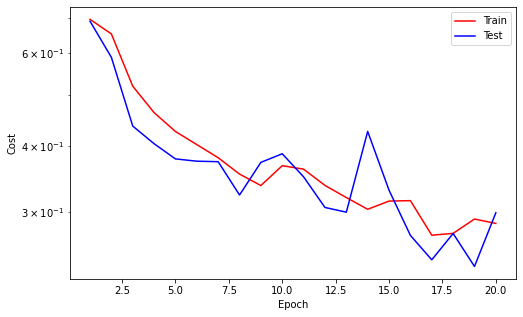

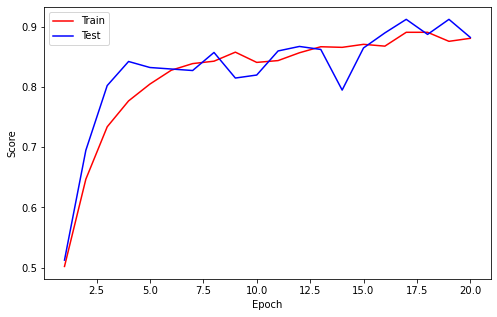

==> EarlyStop patience =  3 | Best test_score: 0.9125


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.2619 | Test_cost  = 0.2383 | Train_score = 0.8840 | Test_score = 0.8925 |
==> EarlyStop patience =  4 | Best test_score: 0.9125


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.2598 | Test_cost  = 0.2188 | Train_score = 0.8910 | Test_score = 0.9200 |


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.2295 | Test_cost  = 0.2451 | Train_score = 0.9140 | Test_score = 0.9125 |
==> EarlyStop patience =  1 | Best test_score: 0.9200


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.2181 | Test_cost  = 0.3001 | Train_score = 0.9130 | Test_score = 0.8875 |
==> EarlyStop patience =  2 | Best test_score: 0.9200


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.2026 | Test_cost  = 0.2155 | Train_score = 0.9190 | Test_score = 0.9150 |
==> EarlyStop patience =  3 | Best test_score: 0.9200


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.2422 | Test_cost  = 0.2800 | Train_score = 0.9090 | Test_score = 0.8900 |
==> EarlyStop patience =  4 | Best test_score: 0.9200


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.2215 | Test_cost  = 0.2023 | Train_score = 0.9160 | Test_score = 0.9325 |


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.1898 | Test_cost  = 0.2032 | Train_score = 0.9190 | Test_score = 0.9175 |
==> EarlyStop patience =  1 | Best test_score: 0.9325


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.2028 | Test_cost  = 0.2213 | Train_score = 0.9240 | Test_score = 0.9050 |
==> EarlyStop patience =  2 | Best test_score: 0.9325


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.1791 | Test_cost  = 0.1841 | Train_score = 0.9280 | Test_score = 0.9200 |
==> EarlyStop patience =  3 | Best test_score: 0.9325


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.1857 | Test_cost  = 0.2161 | Train_score = 0.9320 | Test_score = 0.9250 |
==> EarlyStop patience =  4 | Best test_score: 0.9325


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.1759 | Test_cost  = 0.2125 | Train_score = 0.9300 | Test_score = 0.9150 |
==> EarlyStop patience =  5 | Best test_score: 0.9325
==> Execute Early Stopping at epoch: 32 | Best test_score: 0.9325
==> Best model is saved at model


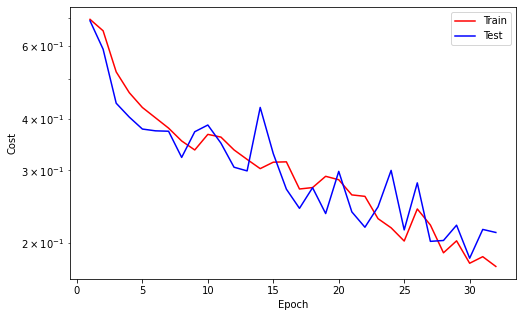

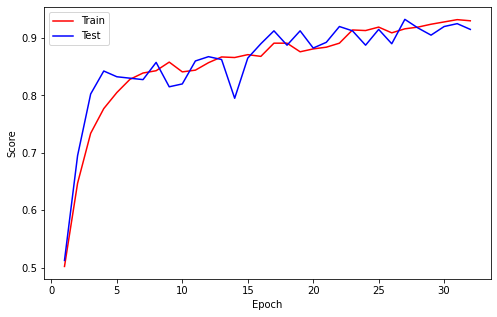

In [12]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    #Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    #Checkpoint
    callback.save_checkpoint()
    
    #Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    #Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# **Predict**

In [13]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [14]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 1])

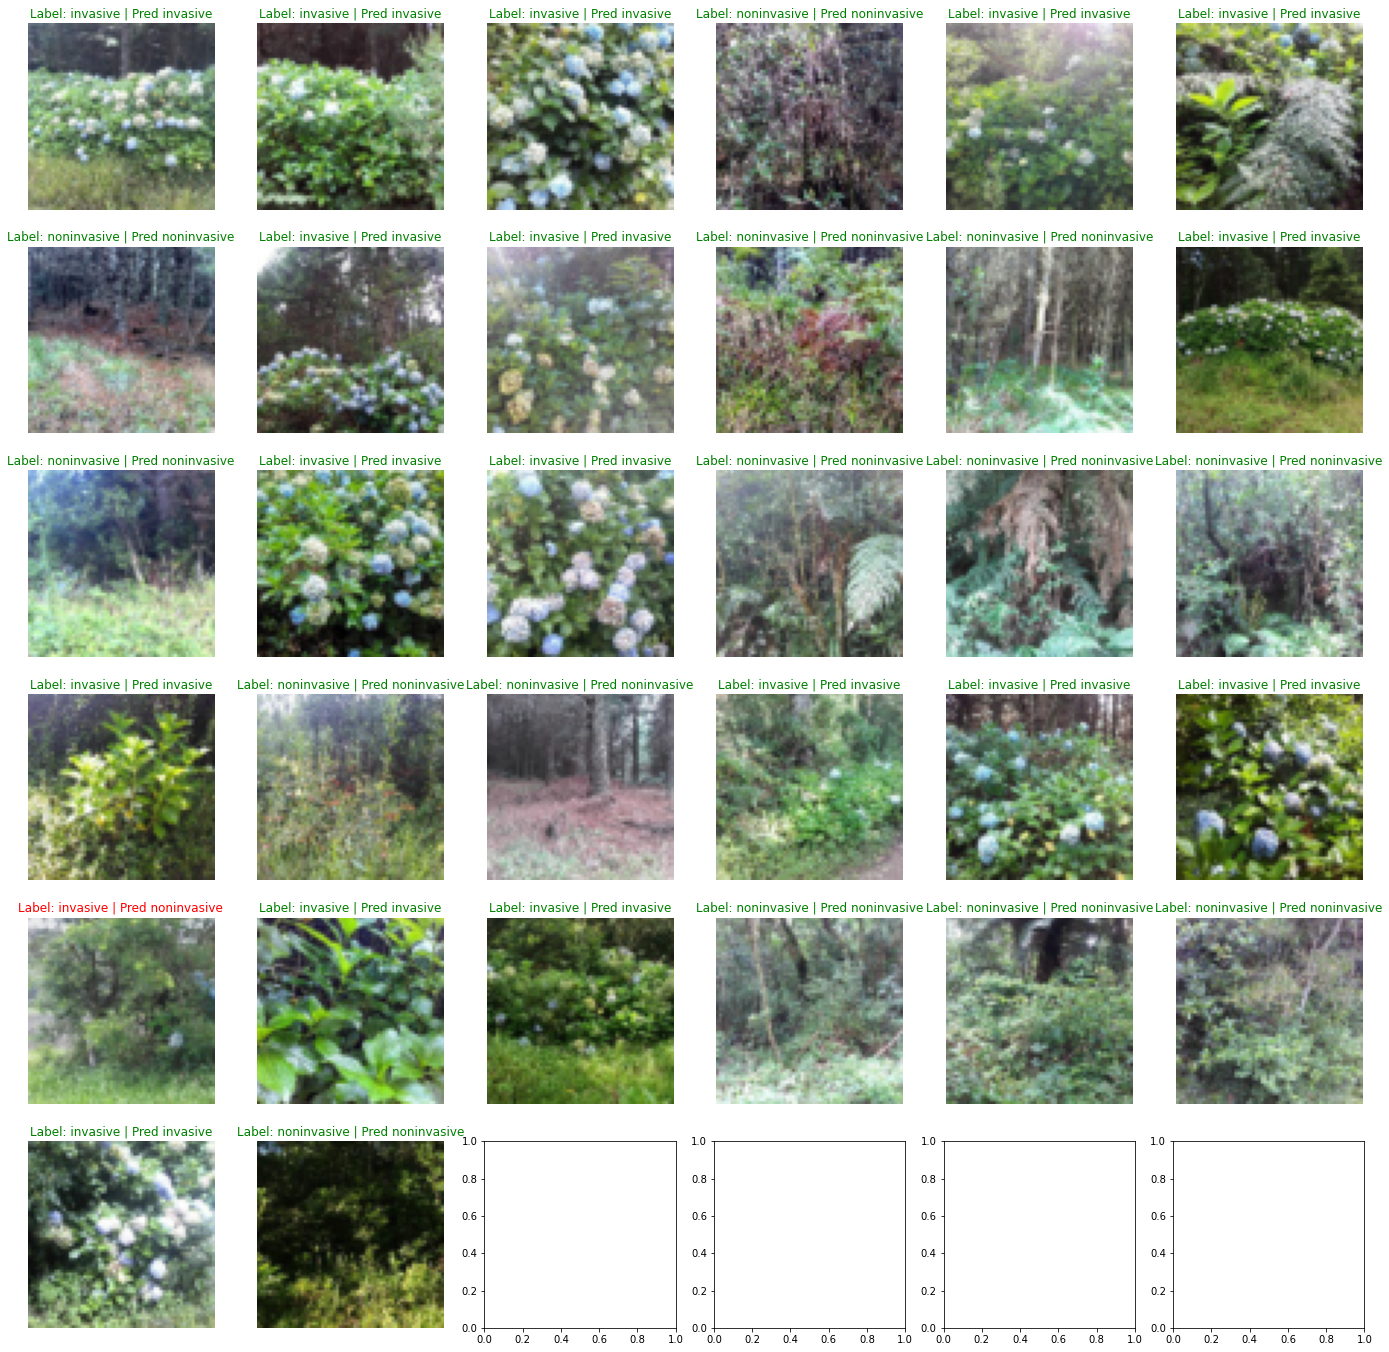

In [15]:
fig, axes = plt.subplots(6, 6, figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color":"r"} if label != pred else {"color":"g"}
    label, pred = labelcat[label.item()], labelcat[pred.item()]
    ax.set_title(f"Label: {label} | Pred {pred}", fontdict = font)
    ax.axis("off")